# Setup

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rc = {
    "font.family": "sans",
    "font.size": 10,
    "axes.axisbelow": True,
    "grid.linestyle": '--',
    "axes.grid": True,
    "mathtext.fontset": "cm",
    "grid.alpha": 0.3
}

plt.rcParams.update(rc)


# Data prep

In [106]:
from q_factor import get_q_df


In [107]:
q_values = get_q_df('./data/QVALUES.txt')

q_values['Q'] = q_values['Q'] * 1

q_values


,i_ref,Q
0,0.0,22.709
1,0.1,27.925
2,0.2,32.978
3,0.3,38.767
4,0.4,46.492
5,0.5,56.466
6,0.6,68.512
7,0.7,84.725
8,0.8,115.720
9,0.9,164.860


# Testing the numerical methods

## Secant

In [108]:
from q_factor import q_func_polynomial
from methods import secant, mod_secant, bisection


In [109]:
def build_test(test_dict: dict, q_values: pd.DataFrame, q_func_polynomial: callable, method: callable, show_results=False):
    a = test_dict['a']
    b = test_dict['b']
    seek = test_dict['seek']
    tol = test_dict['tol']
    MAX_ITER = test_dict['max_iter']

    x = np.arange(0, 1, 1e-3)
    f = q_func_polynomial(x, q_values, deg=9, include_q_drop=False)

    results = method(a, b, seek, tol, f, MAX_ITER, debug=True)

    return results


In [110]:
def multiple_seeks_test(start, stop, step, method_label, test_dict_copy, *args, **kwargs):
    multiple_seeks = np.arange(start, stop, step)
    m_seeks_records = []

    for seek in multiple_seeks:
        test_dict_copy['seek'] = seek
        
        m_seeks_dict = dict()

        r = build_test(*args, **kwargs)

        m_seeks_dict['Method'] = method_label
        m_seeks_dict['Seek'] = seek
        m_seeks_dict['Iters-to-converge'] = r['iter'].iat[-1]
        m_seeks_dict['c'] = r['c'].iat[-1]
        m_seeks_dict['f(c)'] = r['f(c)'].iat[-1]

        m_seeks_records.append(m_seeks_dict)

    return pd.DataFrame(m_seeks_records)


In [111]:
def get_mock_y(include_q_drop):
  x = np.arange(0, 1, 1e-3)
  f = q_func_polynomial(x, q_values, include_q_drop=include_q_drop)
  y = f(x)

  return y


In [112]:
test_dict = {
    'a': 0.0,
    'b': 1.0,
    'seek': 220,
    'tol': 30,
    'max_iter': 32
}

mock_dict = {
  'x': np.arange(0, 1, 1e-3),
  'y': get_mock_y(include_q_drop=False),
  'y_with_drop': get_mock_y(include_q_drop=True),
}

test_dict_copy = test_dict.copy()

In [113]:
res_secant = build_test(test_dict, q_values,
                        q_func_polynomial,
                        secant,
                        show_results=False)

res_mod_sec = build_test(test_dict,
                         q_values,
                         q_func_polynomial,
                         mod_secant,
                         show_results=False)

res_bisect = build_test(test_dict,
                        q_values,
                        q_func_polynomial,
                        bisection,
                        show_results=False)


In [114]:
res_secant.tail()

,iter,a,b,c,f(c),error
2,3,0.675794,0.869323,1.080612,883.212291,663.212291
3,4,0.869323,1.080612,0.890315,158.693037,-61.306963
4,5,1.080612,0.890315,0.906417,169.295096,-50.704904
5,6,0.890315,0.906417,0.983428,269.647957,49.647957
6,7,0.906417,0.983428,0.945328,205.170300,-14.829700


In [115]:
res_mod_sec.tail()

,iter,a,b,c,f(c),error
0,1,0.8,1.000000,0.904865,168.197989,-51.802011
1,2,1.0,0.904865,0.938516,197.384948,-22.615052


In [116]:
res_bisect.tail()

,iter,a,b,c,f(c),error
0,1,0.000,1.0,0.5000,56.743276,-163.256724
1,2,0.500,1.0,0.7500,98.171202,-121.828798
2,3,0.750,1.0,0.8750,149.876590,-70.123410
3,4,0.875,1.0,0.9375,196.292227,-23.707773


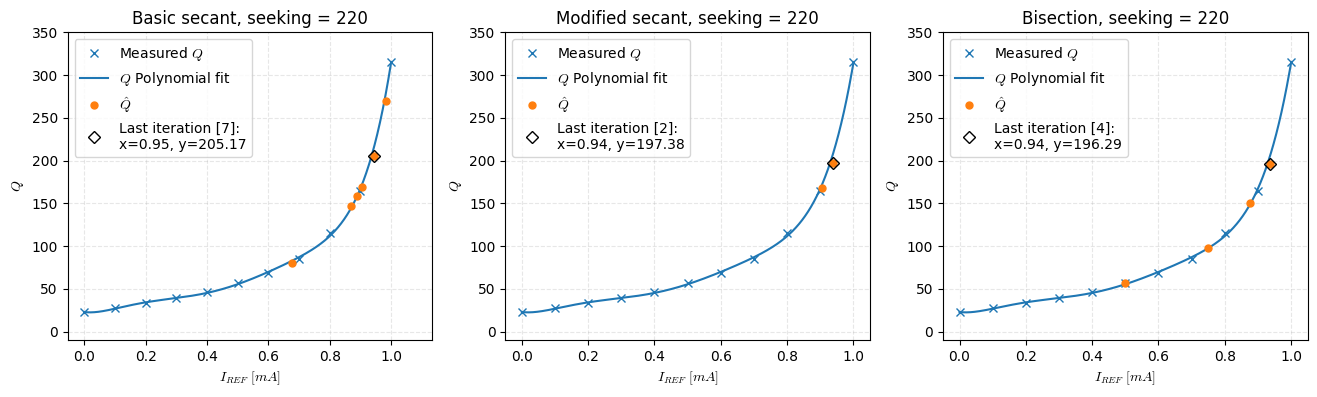

In [122]:
nc = 3
results = [res_secant, res_mod_sec, res_bisect]
titles = ['Basic secant', 'Modified secant', 'Bisection']

fig, ax = plt.subplots(ncols=nc, figsize=(16, 4))

for i in range(nc):
    ax[i].plot(q_values['i_ref'],
               q_values['Q'],
               'x', label='Measured $Q$')

    ax[i].plot(mock_dict['x'],
               mock_dict['y'],
               label='$Q$ Polynomial fit', c='C0')

    ax[i].plot(results[i]['c'],
               results[i]['f(c)'],
               'o', markersize=5, label='$\hat{Q}$')

    last_iref = results[i]['c'].iat[-1]
    last_q = results[i]['f(c)'].iat[-1]
    last_iter = results[i]['iter'].iat[-1]

    ax[i].plot(last_iref,
               last_q,
               'D',
               label=f'Last iteration [{last_iter}]:\nx={last_iref:.2f}, y={last_q:.2f}',
               c='k', fillstyle='none',)

    ax[i].set(
        title=titles[i] + f', seeking = {test_dict["seek"]}',
        xlabel='$I_{REF} \;[mA]$',
        ylabel='$Q$',
        ylim=[-10, 350]
    )
    
for a in ax.flat:
    a.legend()


In [ ]:
test_dict_copy['tol'] = 30

In [ ]:
start = 30
stop = 300
step = 20

test_dict_copy['tol'] = test_dict['tol']

multiple_secant = multiple_seeks_test(
    start, stop, step, 
    'Basic secant', test_dict_copy, test_dict_copy, q_values, q_func_polynomial, secant)

multiple_mod_sec = multiple_seeks_test(
    start, stop, step, 
    'Modified secant', test_dict_copy, test_dict_copy, q_values, q_func_polynomial, mod_secant)

multiple_bisection = multiple_seeks_test(
    start, stop, step, 
    'Bisection', test_dict_copy, test_dict_copy, q_values, q_func_polynomial, bisection)


full_sweep = pd.concat([multiple_secant, multiple_mod_sec, multiple_bisection])
full_sweep['c'] = (full_sweep['c']).round(3)


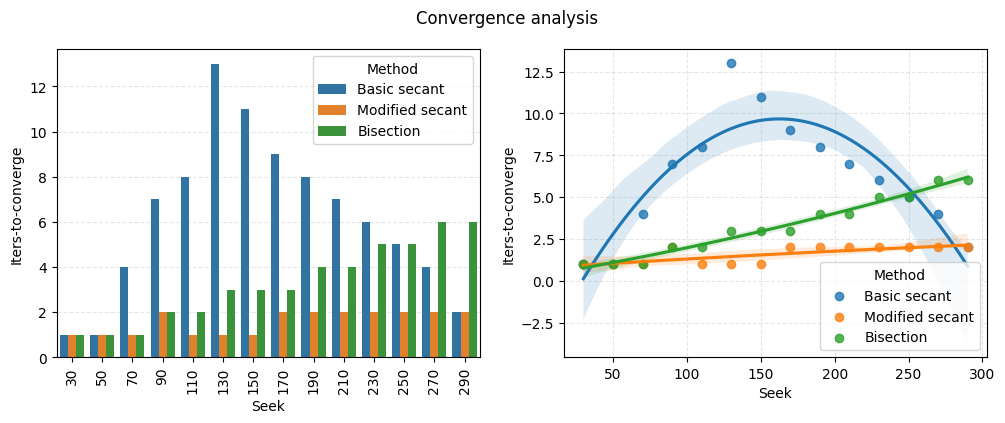

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)

sns.barplot(data=full_sweep,
            y='Iters-to-converge',
            x='Seek',
            hue='Method',
            orient='v',
            ax=ax[0])

ax[0].set_xticklabels(rotation=90, labels=full_sweep['Seek'].unique())


sns.regplot(data=multiple_secant, x='Seek', y='Iters-to-converge',
            ax=ax[1], order=2, label='Basic secant')

sns.regplot(data=multiple_mod_sec, x='Seek', y='Iters-to-converge',
            ax=ax[1], order=2, label='Modified secant')

sns.regplot(data=multiple_bisection, x='Seek', y='Iters-to-converge',
                        ax=ax[1], order=2, label='Bisection')

ax[1].legend(title='Method')

fig.suptitle('Convergence analysis')


plt.show()


In [ ]:
full_sweep

,Method,Seek,Iters-to-converge,c,f(c)
0,Basic secant,30,1,0.025,26.494039
1,Basic secant,50,1,0.093,27.816730
2,Basic secant,70,4,0.487,55.316055
3,Basic secant,90,7,0.646,74.659821
4,Basic secant,110,8,0.711,87.462432
5,Basic secant,130,13,0.810,119.815393
6,Basic secant,150,11,0.834,129.877547
7,Basic secant,170,9,0.925,184.388065
8,Basic secant,190,8,0.914,174.704311
9,Basic secant,210,7,0.928,186.950873


In [ ]:
# speedup = basic['Iters-to-converge'].values / modif['Iters-to-converge'].values

# mean_speedup = np.mean(speedup)

# fig, ax = plt.subplots(figsize=(7, 5))

# ax.plot(basic['Seek'], speedup, '-o', label='Speedup')
# ax.axhline(mean_speedup, ls='--', c='k', alpha=0.5,
#            label=f'Mean speedup = {mean_speedup:.2f}')


# ax.set(
#     xlabel='Seek',
#     ylabel='Speedup',
#     title='Speedup (performance gain) from basic to modified method in\niters-to-converge number'
# )

# ax.legend()
# plt.show()


## Bisection

In [ ]:
from methods import bisection


In [ ]:
a = 0.0
b = 0.7
seek = 50
tol = 1e-6
MAX_ITER = 64

x = np.arange(0, 1, 1e-3)
f = q_func_polynomial(x, q_values, deg=12, include_q_drop=True)
y = f(x)

res_bisection = bisection(a, b, seek, tol, f, MAX_ITER, debug=True)

res_bisection


/tmp/ipykernel_15671/3477611551.py:8: RankWarning: Polyfit may be poorly conditioned
  f = q_func_polynomial(x, q_values, deg=12, include_q_drop=True)


,iter,a,b,c,f(c),error
0,1,0.000000,0.700000,0.350000,42.596922,-7.403078e+00
1,2,0.350000,0.700000,0.525000,59.500904,9.500904e+00
2,3,0.350000,0.525000,0.437500,49.757687,-2.423129e-01
3,4,0.437500,0.525000,0.481250,54.289619,4.289619e+00
4,5,0.437500,0.481250,0.459375,51.919067,1.919067e+00
5,6,0.437500,0.459375,0.448437,50.811946,8.119463e-01
6,7,0.437500,0.448437,0.442969,50.278315,2.783149e-01
7,8,0.437500,0.442969,0.440234,50.016397,1.639713e-02
8,9,0.437500,0.440234,0.438867,49.886644,-1.133557e-01
9,10,0.438867,0.440234,0.439551,49.951421,-4.857912e-02


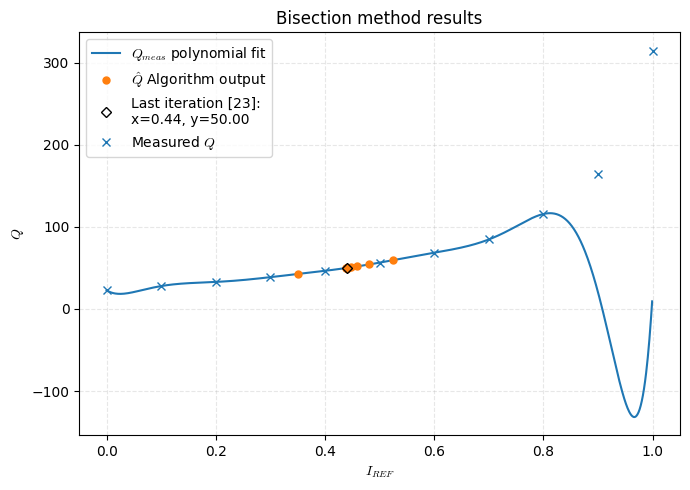

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(7, 5))

ax.plot(x, y, label='$Q_{meas}$ polynomial fit')
ax.plot(res_bisection['c'], res_bisection['f(c)'], 'o',
        label='$\hat{Q}$ Algorithm output', markersize=5)

q_x = res_bisection.iloc[-1, -3]
q_y = res_bisection.iloc[-1, -2]
last_iter = res_bisection.iloc[-1, 0]

ax.plot(q_x, q_y, 'D',
        label=f'Last iteration [{last_iter}]:\nx={q_x:.2f}, y={q_y:.2f}',
        c='k', fillstyle='none', markersize=5)

ax.plot(q_values['i_ref'], q_values['Q'], 'x', c='C0', label='Measured $Q$')

ax.legend()
ax.set(xlabel='$I_{REF}$', ylabel='$Q$', title='Bisection method results')


# a = res_bisection['a']
# b = res_bisection['b']
# c = res_bisection['c']

# ax.plot(a, np.zeros_like(a), 'o', b, np.zeros_like(b), 'x', c, np.zeros_like(c), '+')

fig.tight_layout()
plt.show()


In [ ]:
x0 = 0.0
x1 = 1.0
multiple_seeks = np.arange(25, 300, 20)
tol = 10
MAX_ITER = 32

x = np.arange(0, 1, 1e-3)
f = q_func_polynomial(x, q_values, include_q_drop=False)
y = f(x)

m_seeks_records = []
for seek in multiple_seeks:
    m_seeks_dict = dict()

    res_secantant = secant(x0, x1, seek, tol, f, MAX_ITER, debug=True)
    m_seeks_dict['Method'] = 'basic'
    m_seeks_dict['Seek'] = seek
    m_seeks_dict['Iters-to-converge'] = res_secantant['iter'].iat[-1]
    m_seeks_dict['x_next'] = res_secantant['x_next'].iat[-1]
    m_seeks_dict['f(x_next)'] = res_secantant['f(x_next)'].iat[-1]

    m_seeks_records.append(m_seeks_dict)

    m_seeks_dict = dict()

    res_mod = mod_secant(x0, x1, seek, tol, f, MAX_ITER, debug=True)
    m_seeks_dict['Method'] = 'modified'
    m_seeks_dict['Seek'] = seek
    m_seeks_dict['Iters-to-converge'] = res_mod['iter'].iat[-1]
    m_seeks_dict['x_next'] = res_mod['x_next'].iat[-1]
    m_seeks_dict['f(x_next)'] = res_mod['f(x_next)'].iat[-1]

    m_seeks_records.append(m_seeks_dict)

m_seeks_df = pd.DataFrame(m_seeks_records)
m_seeks_df.tail(4)


KeyError: 'x_next'